## The modified SEIR model

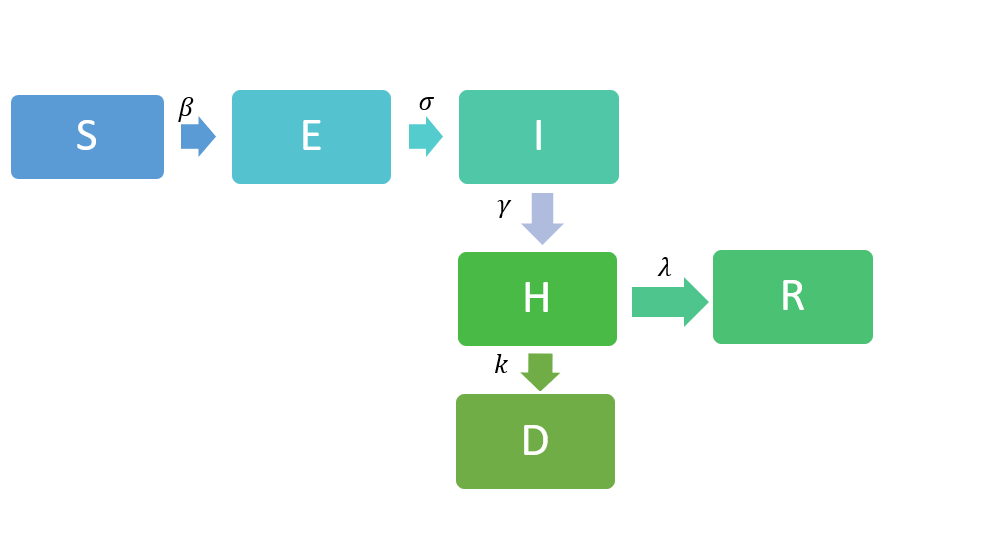
In this modified SEIR model, we have __6__ compartments: __S(susceptible)__, __E(exposed)__, __I(infectious)__, __R(recovered)__, __H(hospitalized)__, __D(dead)__.<br>
Our model is given by:<br>
\begin{equation}
S(t+1) = S(t) - \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} - \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)}\\
E(t+1) = E(t) + \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} + \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)} - \sigma \times E(t)\\
I(t+1) = I(t) + \sigma \times E(t) - \gamma \times I(t)\\
H(t+1) = H(t) + \gamma \times I(t) -\lambda \times H(t) - k \times H(t)\\
R(t+1) = R(t) + \lambda \times H(t)
D(t+1) = k \times H(t)
\end{equation}

__There are 7 parameters in the model:__ <br>


$\beta_{1}$: The rate of transmission for the susceptible to infected (0.15747;).<br>
$\beta_{2}$: The rate of transmission for the susceptible to exposed (0.78735).<br>
$r$: The contact rate (3).<br>
$\sigma$: The incubation rate ($\frac{1}{7}$).<br>
$\gamma$: The hospitalization rate (0.22).<br>
$\lambda$: The recovery rate (0.014).<br>
$k$: The mortality rate by covid-19 (2.7*10^(-4)).<br>

Most of the values of these parameters refer to the article form Nanshan Zhong team.<br>

## Model Simulation
Firstly, I tried to use DoobGillespie algorithm (refer to Yoni's book),The detail is shown below.

#### 1. DoobGillespie algorithm

In [78]:
using Distributions, Random, Plots;
Random.seed!(0);

In [175]:
# the function that implements DoobGillespie simulation
function moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,T,M,I0)
    # set the inital value 
    t, S, E, I, H, R, D = 0.0, M-I0, 0, I0*(1-gamma), I0*gamma, 0, 0
    # initialize results list
    tValues, sValues, eValues, iValues, hValues, rValues, dValues = [t], [S], [E], [I], [H], [R], [D]
    # main loop
    while t<T
        exposedRate = beta_1*r*I*S/M + beta_2*r*E*S/M
        infectionRate = sigma*E
        hospitalizationRate = gamma*I
        deathRate = k*H
        recoveredRate = lambda*H
        
        totalRate = exposedRate + infectionRate + hospitalizationRate + deathRate + recoveredRate 
        probs = [exposedRate,infectionRate,hospitalizationRate,deathRate,recoveredRate]/totalRate
        
        # generate exponentially distributed random variable t
        t += rand(Exponential(1/(totalRate)))
        u = rand()
       
        if u < probs[1]
            S -= 1; E += 1
        elseif u < probs[2]
            E -=1; I += 1
        elseif u < probs[3]
            I -= 1; H += 1
        elseif u < probs[4]
            H -= 1; D += 1
        elseif u < probs[5]
            H -= 1; R += 1
     
        end
        push!(tValues,t);
        push!(sValues,S);
        push!(eValues,E);
        push!(iValues,I);
        push!(rValues,R);
        push!(hValues,H);
        push!(dValues,D);
        I == 0  && break
    end
    return [tValues, sValues, eValues, iValues, rValues, hValues, dValues]
end

moderatedSEIRDoobGillespie (generic function with 1 method)

In [176]:
# the values of all parameters
# the rate of transmission for the susceptible to infected 
beta_1 = 0.15747;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.78735;

# the contact rate
r = 3.0;

# the incubation rate
sigma = 1/7;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.01;

# The mortality rate by covid-19
k = 2.7*10^(-4);

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

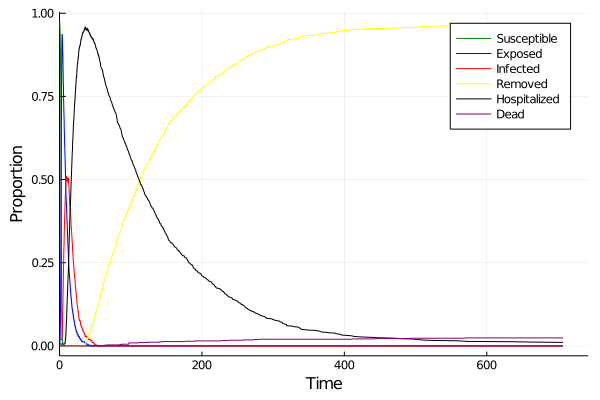

In [178]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,700,M,I0);
p3 = plot(tV,sV/M,label = "Susceptible", c=:green)
plot!(tV,eV/M,label = "Exposed", c=:blue)
plot!(tV,iV/M,label = "Infected",c=:red)
plot!(tV,rV/M,label = "Removed",c=:yellow)
plot!(tV,hV/M,label = "Hospitalized", c=:black)
plot!(tV,dV/M,label = "Dead", c=:purple,
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))

Then I intened to use __markov chain__ to plot the model trajectory.

#### 2. Markov Chain 

In [122]:
# the function that implements Markov Chain method
function modifiedSEIRMarkovChian(beta_1,beta_2,r,sigma,gamma,lambda,k,T,M,I0)
    # set the inital value 
    S, E, I, H, R, D = (M-I0)*1.0, 0.0, I0*(1-gamma), I0*gamma, 0.0, 0.0
    # initialize results list
    sValues, eValues, iValues, hValues, rValues, dValues = [S], [E], [I], [H], [R], [D]
    
    # main loop
    for idx in 1:(T-1)
        push!(sValues,sValues[idx] - (beta_1*r*iValues[idx]*sValues[idx])/M - (beta_2*r*eValues[idx]*sValues[idx])/M)
        push!(eValues,eValues[idx] + (beta_1*r*iValues[idx]*sValues[idx])/M + (beta_2*r*eValues[idx]*sValues[idx])/M - sigma*eValues[idx])
        push!(iValues,iValues[idx] + sigma*eValues[idx] - gamma*iValues[idx])
        push!(hValues,hValues[idx] - lambda*hValues[idx] + gamma*iValues[idx] - k*hValues[idx])
        push!(rValues,rValues[idx] +  lambda*hValues[idx])
        push!(dValues,dValues[idx] + k*hValues[idx])
        I == 0  && break
    end
    
    return [sValues, eValues, iValues, rValues, hValues, dValues]
end   

modifiedSEIRMarkovChian (generic function with 1 method)

In [127]:
# the values of all parameters
# the rate of transmission for the susceptible to infected 
beta_1 = 0.15747;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.78735;

# the contact rate
r = 3.0;

# the incubation rate
sigma = 1/7;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.01;

# The mortality rate by covid-19
k = 2.7*10^(-4);

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

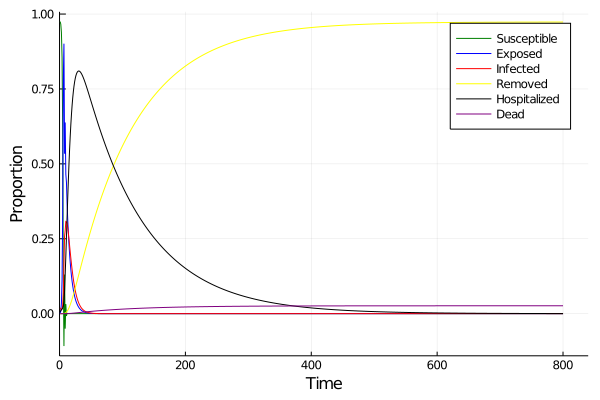

In [179]:
sV_1, eV_1, iV_1, rV_1, hV_1, dV_1 = modifiedSEIRMarkovChian(beta_1,beta_2,r,sigma,gamma,lambda,k,800,M,I0);
p4 = plot(1:length(sV_1),sV_1/M,label = "Susceptible", c=:green)
plot!(1:length(eV_1),eV_1/M,label = "Exposed", c=:blue)
plot!(1:length(iV_1),iV_1/M,label = "Infected",c=:red)
plot!(1:length(rV_1),rV_1/M,label = "Removed",c=:yellow)
plot!(1:length(hV_1),hV_1/M,label = "Hospitalized", c=:black)
plot!(1:length(dV_1),dV_1/M,label = "Dead", c=:purple,
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,length(dV_1)*1.05))

The two plots above are similar to each other. 
However, the trajectory of proportion of susceptible is a bit unreasonable, because some values of it are negative. Comapred to it, the simulated trajectory obtained from Gillespie algorithm seems to be more reasonable , because not only all values are greater than 0. 